# Импорт 

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [50]:
plt.style.use('dark_background')

# Код из предоставленных материалов

In [51]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [52]:
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);
    plt.tight_layout()


In [53]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


In [54]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [55]:
def vis_weigths(weights):
    numbers = np.arange(0,len(weights))
    tick_labels = ['w'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels );

In [56]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);

In [57]:
def to_polynom(x, order = 1, add_bias = False):
#     print(x)
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]
#     print(x)
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
#     print(out)
    return out.reshape(-1, x.size).T



In [58]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  


In [59]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term
                  
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

In [60]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

# Задание 1. Синтетический набор данных

## Первый набор данных

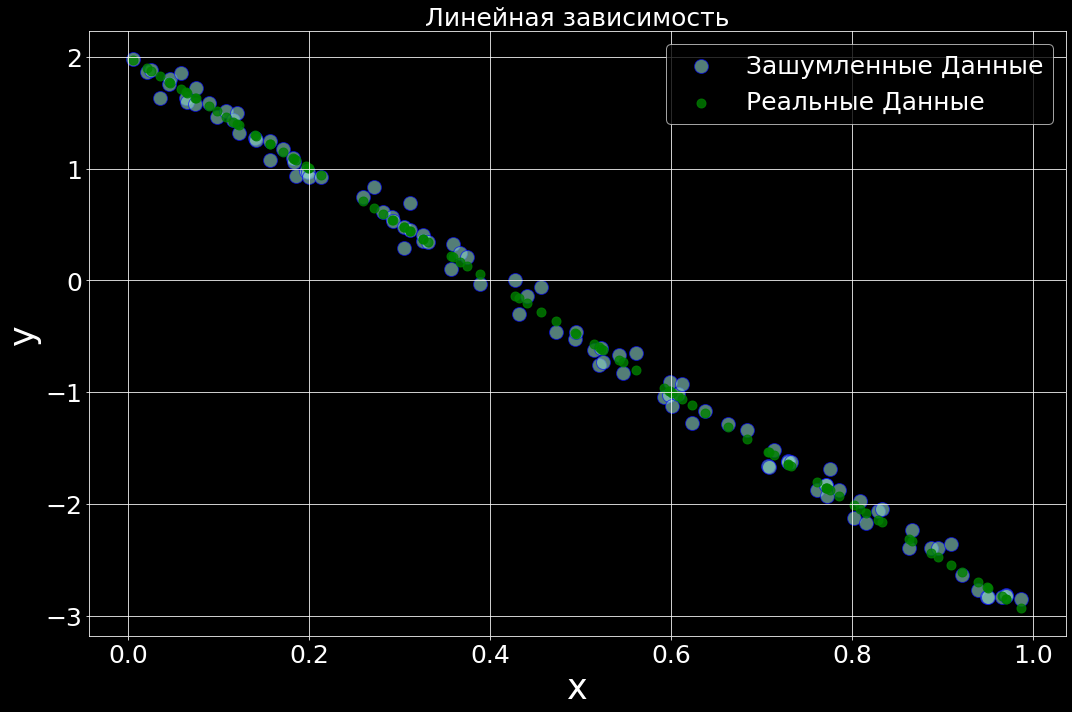

In [13]:
#Линейные данные с небольшим шумом
noise_power = 0.1

y, y_true, x = dataset(a = -5, b = 2,
                       f = None,  N = 100,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')

Test Score = 0.85, Train Score = 0.86


<Figure size 1080x720 with 0 Axes>

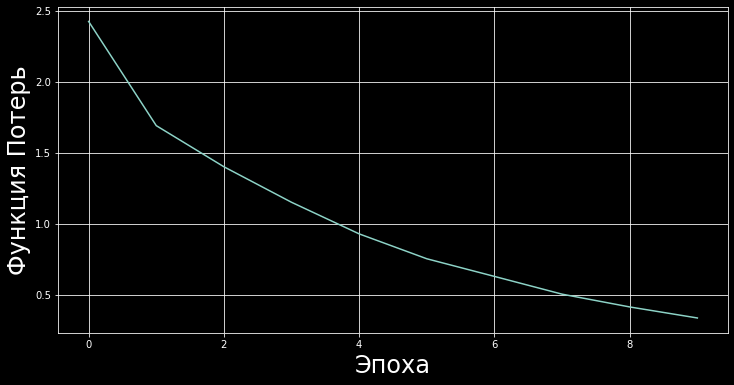

In [14]:
#Обучаем линейную регрессию на линейных данных
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )

regr_poly_lin = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)

regr_poly_lin.fit(x_train, y_train)


fig  = plt.figure(figsize=(15,10))

print(f'Test Score = {regr_poly_lin.score(np.reshape(x_test,30), y_test):.2f}, Train Score = {regr_poly_lin.score(x_train, y_train):.2f}')
# plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly_lin)
regr_poly_lin.plot_cost()
plt.show()

На тестовых данных линейная регрессия показывает себя лучше, чем случайное угадывание.

## Второй набор данных

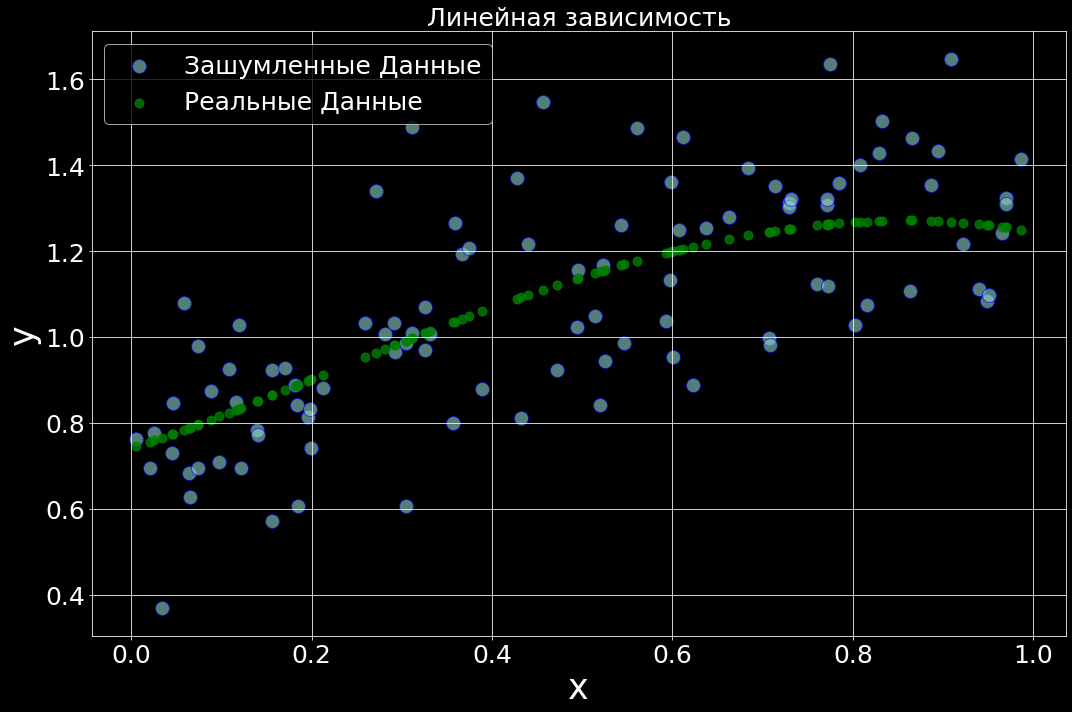

In [15]:
# Создадим не линейные данные, с тремя параметрами и функцией квадратного корня
noise_power = 0.2

y, y_true, x = dataset(a = [1,2,-2], b = 0.55,
                       f = np.sqrt,  N = 100,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')

Test Score = 0.30, Train Score = 0.56


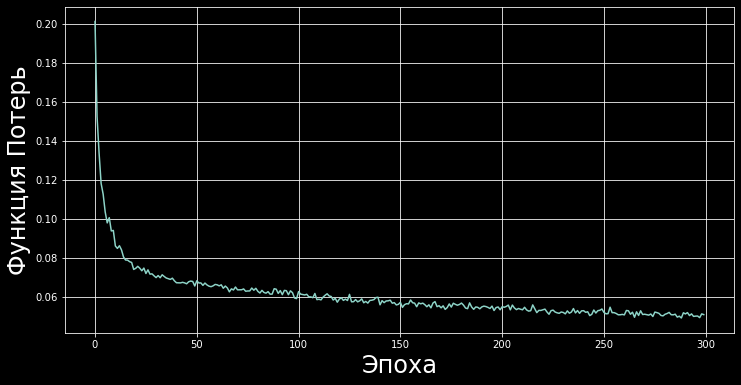

In [16]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )

order  = 4

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail(4)

regr_harm_poly = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly.fit(x_train_, y_train)
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()

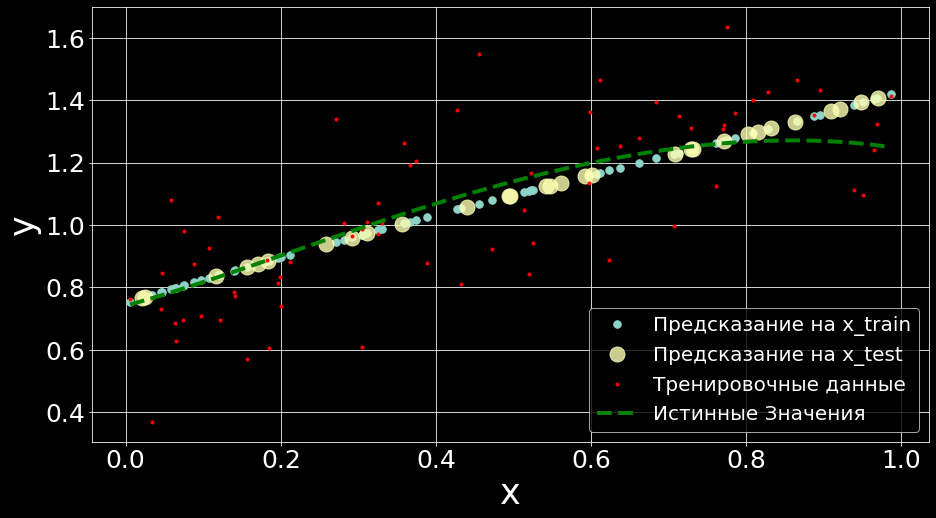

In [17]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_harm_poly)

Данные оказались сложными для нашей регрессии. Попоробуем улучшить результат с помощью регуляризации.

### Применяем эластичную регуляризацию

Test Score = 0.35, Train Score = 0.53


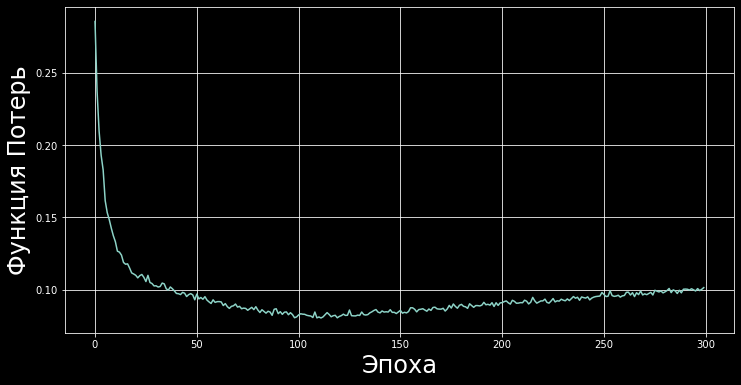

In [18]:
regr_l1l2 = ElasticRegression(learning_rate=0.05,
                         epochs=300,batch_size=25,
                         l1_penalty = 0.01,l2_penalty = 0.1 )
regr_l1l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l1l2.score(x_test_, y_test):.2f}, Train Score = {regr_l1l2.score(x_train_, y_train):.2f}')
regr_l1l2.plot_cost()
plt.show()

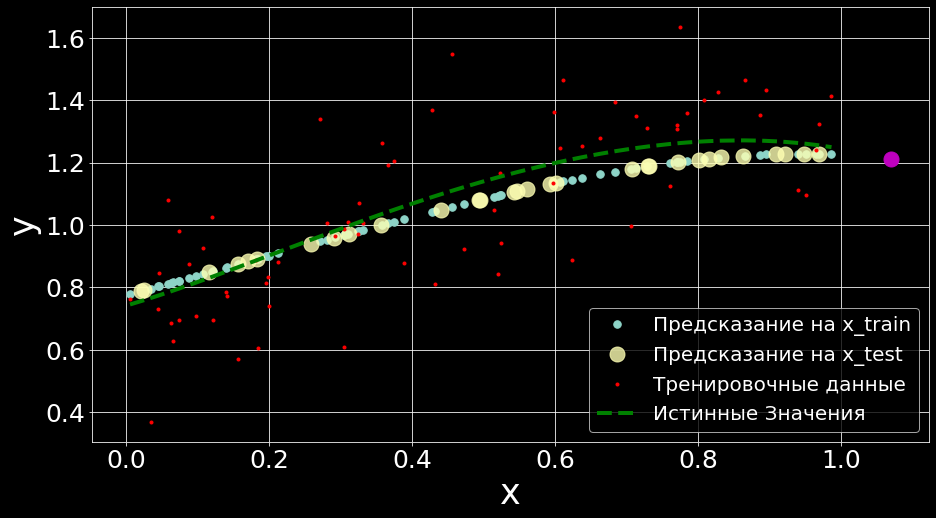

In [19]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1l2)

plt.plot([1.07], 
         regr_l1l2.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

Изменив значения l1 и l2 удалось повысить качество модели на 0.05. Так как изначальные данные сильно раззбросаны и имеют явно не линейную зависимость, то это хорошее улучшение при минимальных затратах.

## Третий набор данных

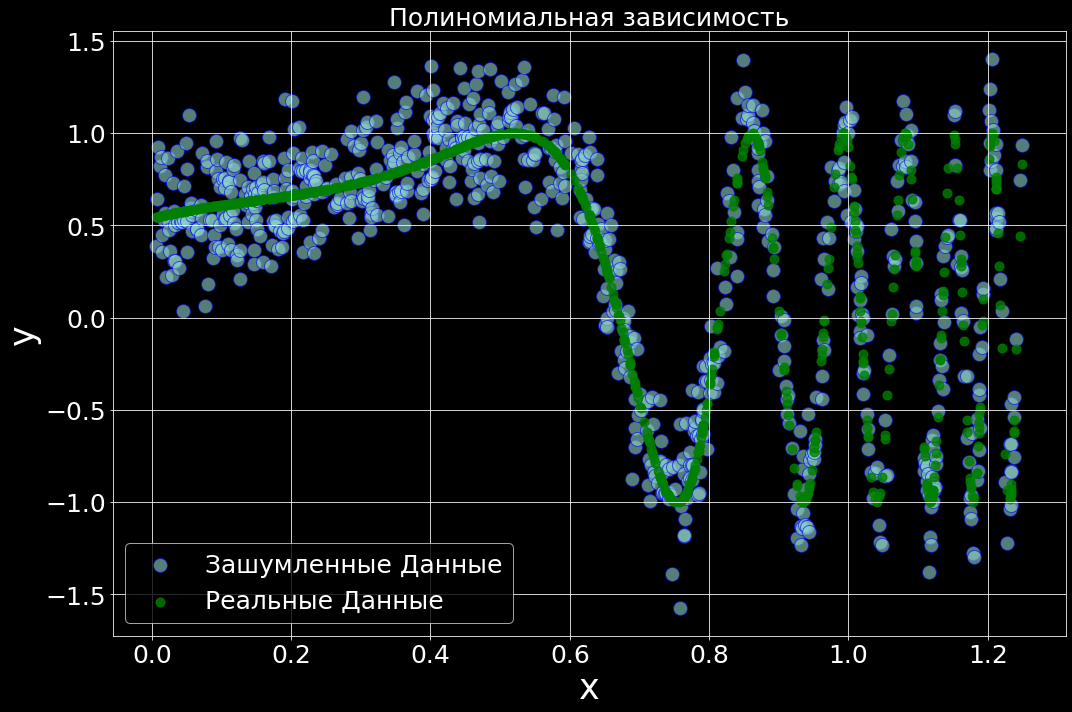

In [20]:
#Добавим еще больше a и изменим функцию на гармоническую
noise_power = 0.2

y, y_true, x = dataset(a = [1,-2,3,4,8], b = -1,
                       f = np.cos,  N = 800,
                       x_max =1.25, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

In [21]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    


order  = 8

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail(4)



,0,1,2,3,4,5,6,7
556,0.309664,0.095892,0.029694,9.195205e-03,2.847421e-03,8.817432e-04,2.730439e-04,8.455179e-05
557,1.070612,1.146211,1.227147,1.313799e+00,1.406569e+00,1.505890e+00,1.612225e+00,1.726068e+00
558,0.971434,0.943683,0.916726,8.905382e-01,8.650988e-01,8.403861e-01,8.163793e-01,7.930583e-01
559,0.018181,0.000331,0.000006,1.092584e-07,1.986409e-09,3.611458e-11,6.565931e-13,1.193741e-14


Test Score = 0.20, Train Score = 0.28


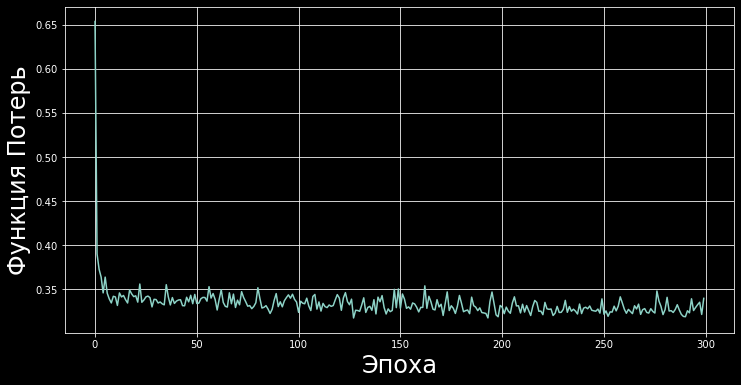

In [22]:
regr_harm_poly = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=40,
                        n_batches=None
                        )

regr_harm_poly.fit(x_train_, y_train)
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()

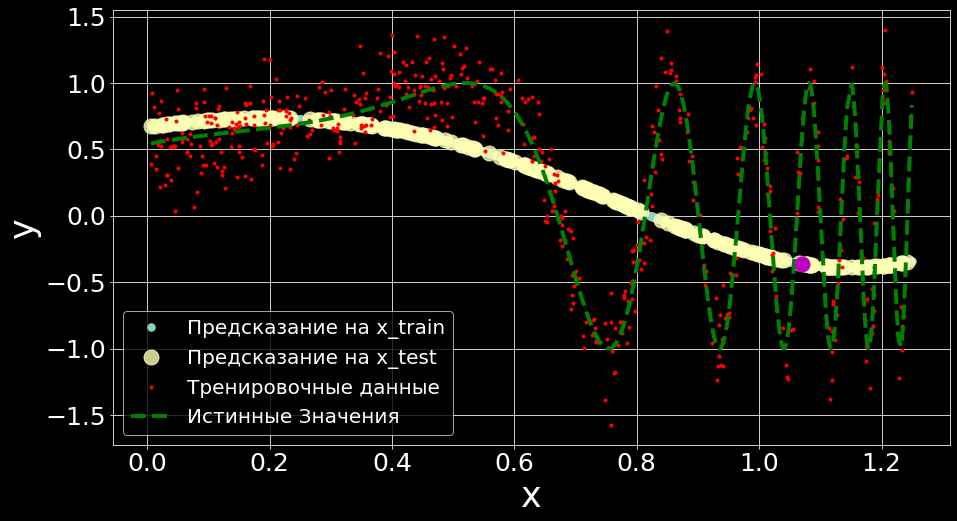

In [23]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_harm_poly)



plt.plot([1.07], 
         regr_harm_poly.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

Данные стали еще сложнее, хотя и был увеличен полином, но 0.2 довольно низкий результат. Попробуем l1 регуляризацию.

## L1

Test Score = 0.25, Train Score = 0.32


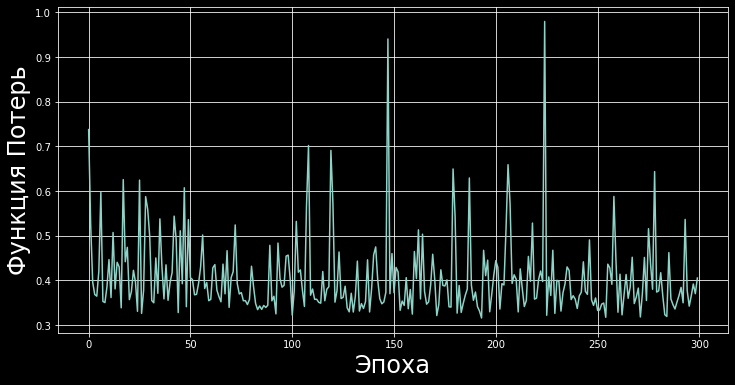

In [24]:
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=40,
                       l1_penalty = 0.00001)
regr_l1.fit(x_train_, y_train)

print(f'Test Score = {regr_l1.score(x_test_, y_test):.2f}, Train Score = {regr_l1.score(x_train_, y_train):.2f}')
regr_l1.plot_cost()

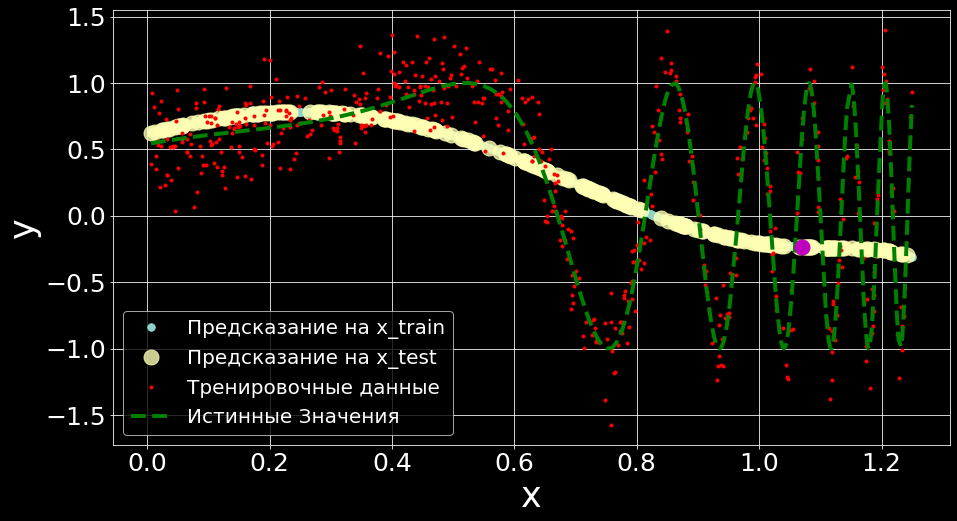

In [25]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1)

plt.plot([1.07], 
         regr_l1.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

После того, как поиграл с параметром l1, регуляризацию улучшили модель на 0.05. Чтобы улучшить еще можно изменять степень полинома.

# Задание 2. Car Moldova

In [61]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year','Price_per_distance']

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('new_columns.csv', delimiter = ',')

df_num = data[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train1)
X_train1 = scaler.transform(X_train1) 
X_test1  = scaler.transform(X_test1) 
df_num.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
 4   km_year               32220 non-null  float64
 5   Price_per_distance    32220 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.5 MB


,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Price_per_distance
0,2011,195000.0,1800.0,7750.0,17727.272727,0.039744
1,2014,135000.0,1500.0,8550.0,16875.000000,0.063333
2,2012,110000.0,1500.0,6550.0,11000.000000,0.059545
3,2006,200000.0,1600.0,4100.0,12500.000000,0.020500
4,2000,300000.0,2200.0,3490.0,13636.363636,0.011633


Test Score = 0.49, Train Score = 0.50


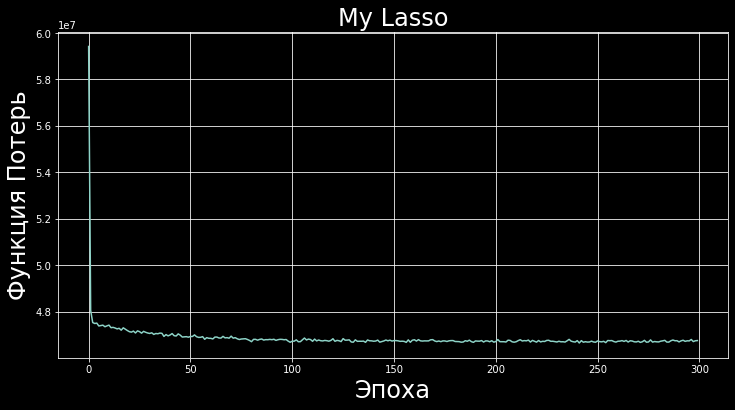

In [63]:
#Возьмем модель, которую использовали для вторых данных
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=40,
                       l1_penalty = 0.00001)
regr_l1.fit(X_train1, y_train1)

print(f'Test Score = {regr_l1.score(X_test1, y_test1):.2f}, Train Score = {regr_l1.score(X_train1, y_train1):.2f}')
regr_l1.plot_cost(title='My Lasso')


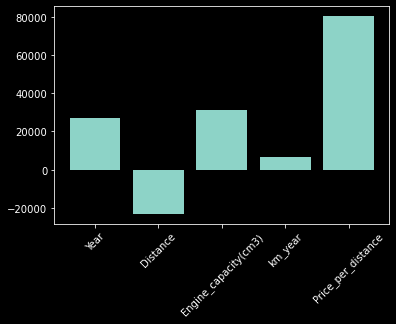

In [65]:
w, b = regr_l1.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 )
plt.show()

Наш новый признак имеет большое влияние на точность функции.

Модель справляется на половину. Попытаемся улучшить с помощью отчистки данных

### Стандартизация

In [66]:
data = pd.read_csv('after_standartization-Copy1.csv', delimiter = ',')

df_num = data[num_columns].copy()

df_num.head()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train1)
X_train1 = scaler.transform(X_train1) 
X_test1  = scaler.transform(X_test1) 
df_num.head()

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Price_per_distance
0,0.376492,0.128983,-0.112516,-0.179081,17727.272727,0.039744
1,0.793761,-0.490816,-0.604496,-0.095044,16875.000000,0.063333
2,0.515582,-0.749065,-0.604496,-0.305136,11000.000000,0.059545
3,-0.318957,0.180633,-0.440503,-0.562500,12500.000000,0.020500
4,-1.153495,1.213632,0.543457,-0.626578,13636.363636,0.011633


train R2: 0.4936; test R2: 0.4821


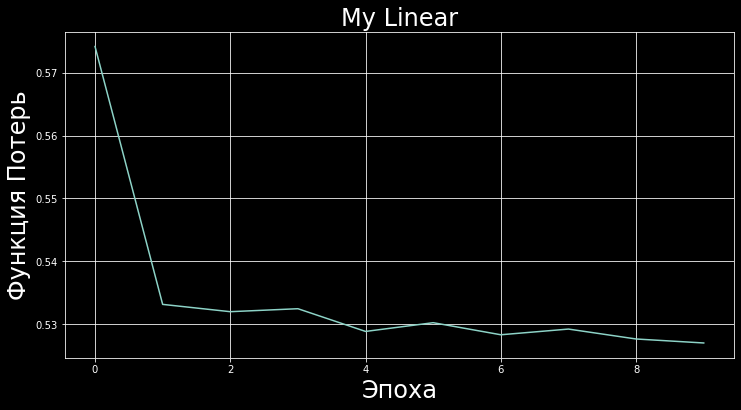

In [67]:
regr = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10)
regr.fit(X_train1, y_train1)

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train1, y_train1), regr.score(X_test1, y_test1)))
regr.plot_cost(title='My Linear')



Test Score = 0.4859, Train Score = 0.4969


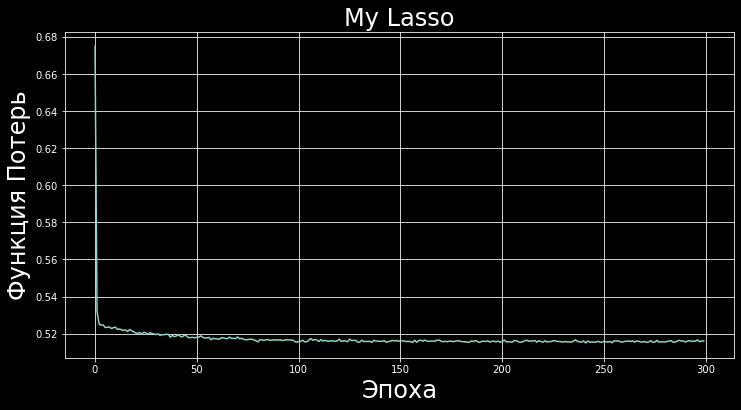

In [68]:
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=40,
                       l1_penalty = 0.00001)
regr_l1.fit(X_train1, y_train1)

print(f'Test Score = {regr_l1.score(X_test1, y_test1):.4f}, Train Score = {regr_l1.score(X_train1, y_train1):.4f}')
regr_l1.plot_cost(title='My Lasso')


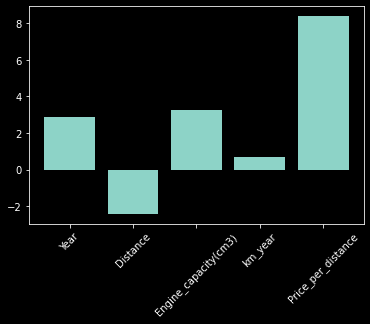

In [69]:
w, b = regr_l1.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 )
plt.show()

Стандартизация не дала заметного улучшения работа способности и результаты стали чуть хуже. Как и должно было быть веса не изменились по влиянию.

### Нормализация

In [70]:
data = pd.read_csv('after_normalization-Copy1.csv', delimiter = ',')

df_num = data[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train1)
X_train1 = scaler.transform(X_train1) 
X_test1  = scaler.transform(X_test1) 
df_num.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  float64
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
 4   km_year               32220 non-null  float64
 5   Price_per_distance    32220 non-null  float64
dtypes: float64(6)
memory usage: 1.5 MB


,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Price_per_distance
0,0.80,0.194919,0.333333,0.075651,17727.272727,0.039744
1,0.86,0.134913,0.270833,0.083667,16875.000000,0.063333
2,0.82,0.109911,0.270833,0.063627,11000.000000,0.059545
3,0.70,0.199920,0.291667,0.039078,12500.000000,0.020500
4,0.58,0.299930,0.416667,0.032966,13636.363636,0.011633


train R2: 0.4929; test R2: 0.4816


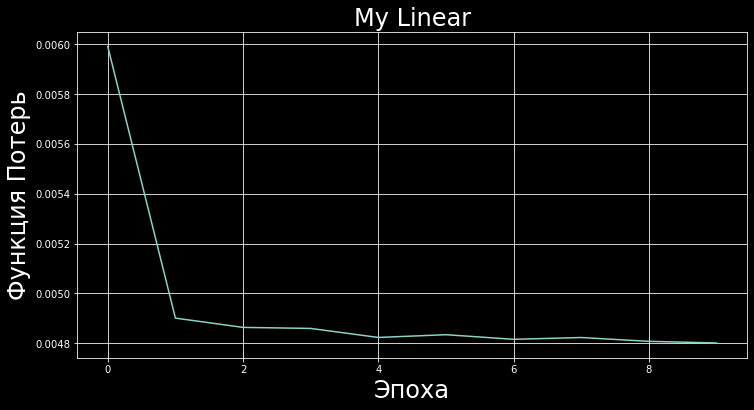

In [71]:
regr = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10)
regr.fit(X_train1, y_train1)

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train1, y_train1), regr.score(X_test1, y_test1)))
regr.plot_cost(title='My Linear')



Test Score = 0.4856, Train Score = 0.4969


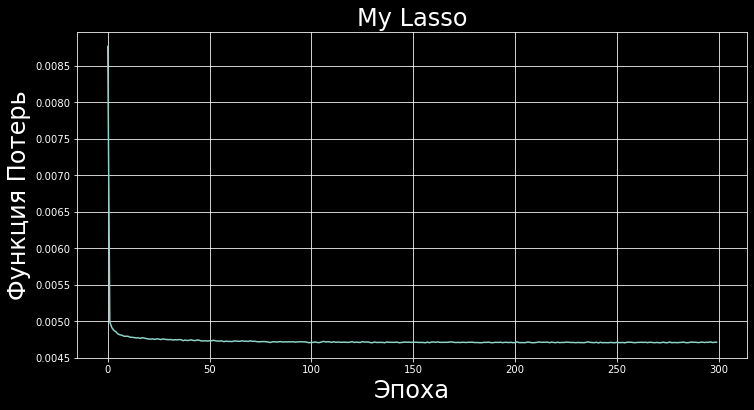

In [72]:
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=40,
                       l1_penalty = 0.00001)
regr_l1.fit(X_train1, y_train1)

print(f'Test Score = {regr_l1.score(X_test1, y_test1):.4f}, Train Score = {regr_l1.score(X_train1, y_train1):.4f}')
regr_l1.plot_cost(title='My Lasso')


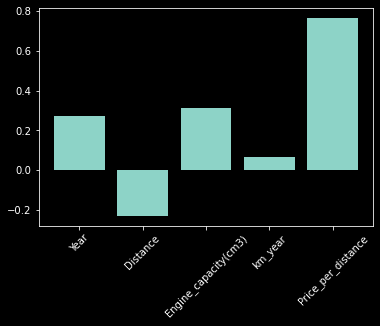

In [73]:
w, b = regr_l1.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 )
plt.show()

Нормализация также как стандартизация не дала больших улучшений и оставила прежними веса.

### Логарифм


In [74]:
data = pd.read_csv('after_log-Copy1.csv', delimiter = ',')

df_num = data[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train1)
X_train1 = scaler.transform(X_train1) 
X_test1  = scaler.transform(X_test1) 
df_num.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  float64
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
 4   km_year               32220 non-null  float64
 5   Price_per_distance    32220 non-null  float64
dtypes: float64(6)
memory usage: 1.5 MB


,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Price_per_distance
0,7.606387,12.180755,7.495542,8.955448,17727.272727,0.039744
1,7.607878,11.813030,7.313220,9.053687,16875.000000,0.063333
2,7.606885,11.608236,7.313220,8.787220,11000.000000,0.059545
3,7.603898,12.206073,7.377759,8.318742,12500.000000,0.020500
4,7.600902,12.611538,7.696213,8.157657,13636.363636,0.011633


train R2: 0.6319; test R2: 0.6203


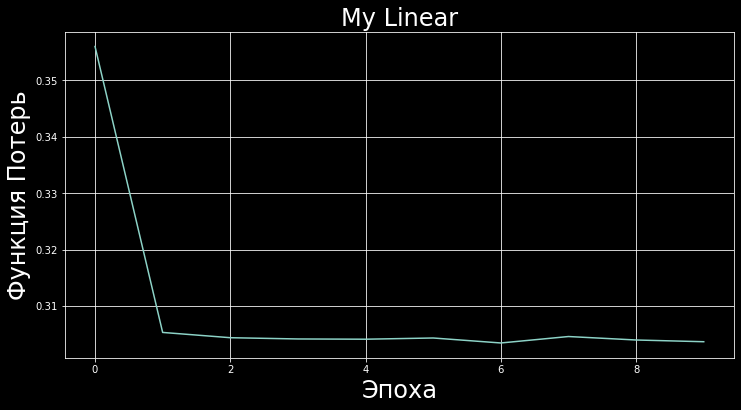

In [75]:
regr = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10)
regr.fit(X_train1, y_train1)

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train1, y_train1), regr.score(X_test1, y_test1)))
regr.plot_cost(title='My Linear')



Test Score = 0.6310, Train Score = 0.6419


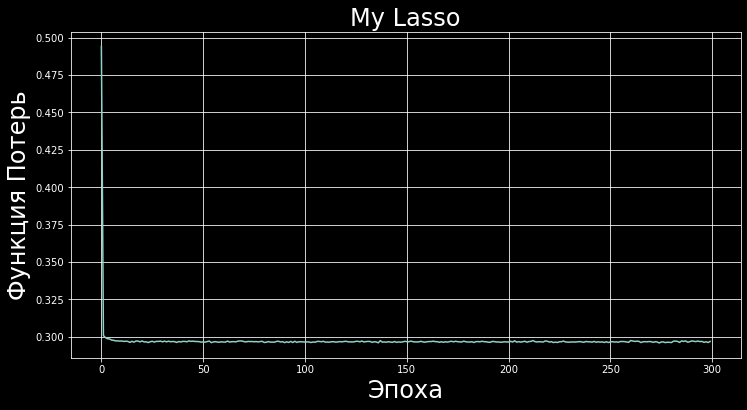

In [76]:
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=40,
                       l1_penalty = 0.00001)
regr_l1.fit(X_train1, y_train1)

print(f'Test Score = {regr_l1.score(X_test1, y_test1):.4f}, Train Score = {regr_l1.score(X_train1, y_train1):.4f}')
regr_l1.plot_cost(title='My Lasso')

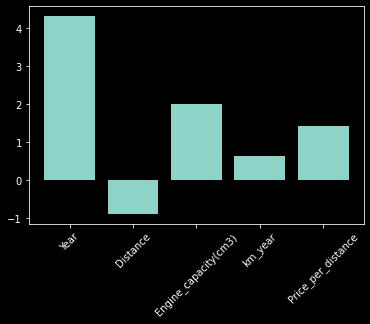

In [77]:
w, b = regr_l1.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 )
plt.show()

Логарифм значительно улучшил точность модели и значения Year стали определяющими.

### Добавление one-hot

In [78]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year','Price_per_distance','Low','High','Medium']

In [79]:
data = pd.read_csv('before_ordinal_encoding-Copy1.csv', delimiter = ',')
data.head()

,Unnamed: 0,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Price_per_distance,Engine_Type
0,0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,7750.0,11,17727.272727,со средним пробегом,0.039744,Meduim
1,1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,8550.0,8,16875.000000,со средним пробегом,0.063333,Low
2,2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,6550.0,10,11000.000000,со средним пробегом,0.059545,Low
3,3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,4100.0,16,12500.000000,со средним пробегом,0.020500,Meduim
4,4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,3490.0,22,13636.363636,со средним пробегом,0.011633,High


In [80]:
dd = data.copy()

In [81]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(data[['Engine_Type']])
dd = dd.assign(High = [i[0] for i in ohe.fit_transform(data[['Engine_Type']])], Low = [i[1] for i in ohe.fit_transform(data[['Engine_Type']])],
              Medium = [i[2] for i in ohe.fit_transform(data[['Engine_Type']])])
dd

,Unnamed: 0,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Price_per_distance,Engine_Type,High,Low,Medium
0,0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,7750.0,11,17727.272727,со средним пробегом,0.039744,Meduim,0.0,0.0,1.0
1,1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,8550.0,8,16875.000000,со средним пробегом,0.063333,Low,0.0,1.0,0.0
2,2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,6550.0,10,11000.000000,со средним пробегом,0.059545,Low,0.0,1.0,0.0
3,3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,4100.0,16,12500.000000,со средним пробегом,0.020500,Meduim,0.0,0.0,1.0
4,4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,3490.0,22,13636.363636,со средним пробегом,0.011633,High,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32215,32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,1,11500.0,6,14666.666667,со средним пробегом,0.130682,Meduim,0.0,0.0,1.0
32216,32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,0,4400.0,20,11250.000000,со средним пробегом,0.019556,Meduim,0.0,0.0,1.0
32217,32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,0,7000.0,7,12714.285714,со средним пробегом,0.078652,Low,0.0,1.0,0.0
32218,32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,0,4000.0,16,23125.000000,с большим пробегом,0.010811,High,1.0,0.0,0.0


In [82]:

df_num = dd[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train1)
X_train1 = scaler.transform(X_train1) 
X_test1  = scaler.transform(X_test1) 
df_num.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
 4   km_year               32220 non-null  float64
 5   Price_per_distance    32220 non-null  float64
 6   Low                   32220 non-null  float64
 7   High                  32220 non-null  float64
 8   Medium                32220 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Price_per_distance,Low,High,Medium
0,2011,195000.0,1800.0,7750.0,17727.272727,0.039744,0.0,0.0,1.0
1,2014,135000.0,1500.0,8550.0,16875.000000,0.063333,1.0,0.0,0.0
2,2012,110000.0,1500.0,6550.0,11000.000000,0.059545,1.0,0.0,0.0
3,2006,200000.0,1600.0,4100.0,12500.000000,0.020500,0.0,0.0,1.0
4,2000,300000.0,2200.0,3490.0,13636.363636,0.011633,0.0,1.0,0.0


train R2: 0.5000; test R2: 0.4913


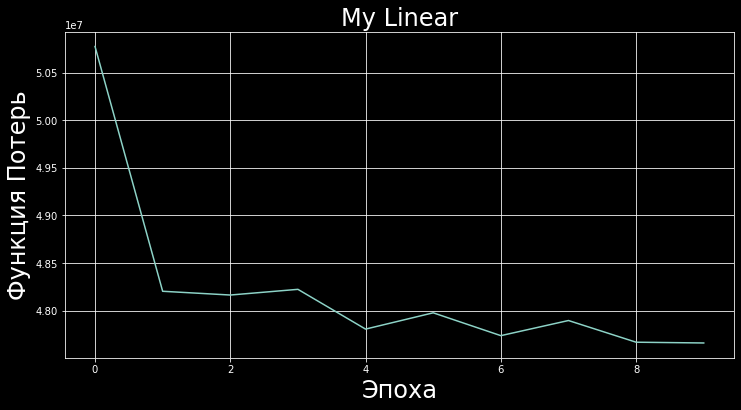

In [83]:
regr = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10)
regr.fit(X_train1, y_train1)

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train1, y_train1), regr.score(X_test1, y_test1)))
regr.plot_cost(title='My Linear')



Test Score = 0.4971, Train Score = 0.5042


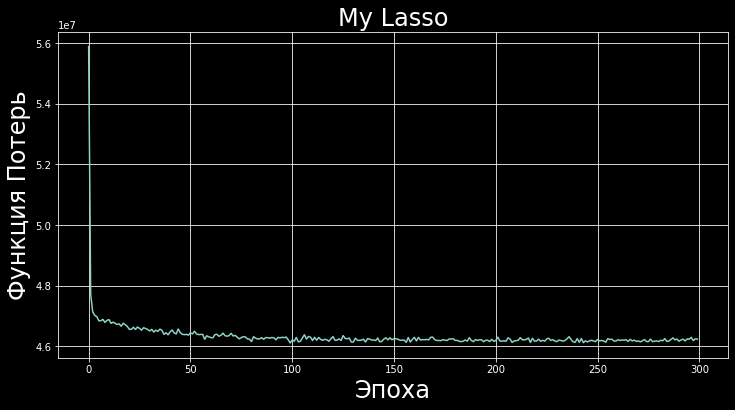

In [84]:
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=40,
                       l1_penalty = 0.00001)
regr_l1.fit(X_train1, y_train1)


print(f'Test Score = {regr_l1.score(X_test1, y_test1):.4f}, Train Score = {regr_l1.score(X_train1, y_train1):.4f}')
regr_l1.plot_cost(title='My Lasso')

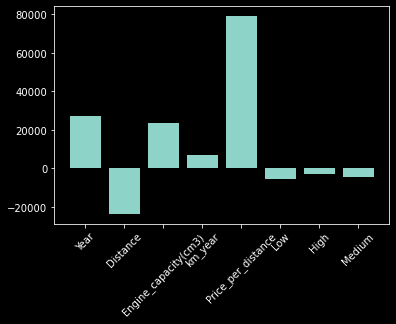

In [85]:
w, b = regr_l1.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 )
plt.show()

Едва заметны улучшения в отличие от первоначального варианта. Новозакодированные признаки оказались не полезными.